In [1]:
%matplotlib inline

# 讓機器認識中文字

###測試於cntk 2.6

![md_images](../Images/hanzi.jpg?raw=true)

## 從錯誤率90幾%到正確率90幾%之路 

In [2]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import math
import random
import glob
from PIL import Image

import cntk as C
from cntk.ops import *
from cntk.layers import *
from cntk.losses import *
from cntk.metrics import *
from cntk.debugging import *
from cntk.logging import *
from cntk.learners import *
from cntk.train import *
from cntk.device import *

# 是否使用GPU
is_gpu = True
if is_gpu:
    try_set_default_device(gpu(0))
else:
    try_set_default_device(cpu())

In [3]:
C.__version__

'2.6'

In [4]:
imgs=glob.glob('../Data/ex02_train/*/*.jpg')
print('圖片數量:{0}'.format(len(imgs)))
print(imgs[:3])
print('')

#list(sorted(set()))去重複排序後產生清單=>產生對應onehot編碼
words=list(sorted(set([im.split('\\')[1] for im in imgs])))
print('中文字數量:{0}'.format(len(words)))
print(''.join(words))

圖片數量:40000
['../Data/ex02_train\\且\\000dcbf63744a53232b396f008a89c5f62344c80.jpg', '../Data/ex02_train\\且\\00207070a7650d5aca1b47df9710f97467b85602.jpg', '../Data/ex02_train\\且\\00456a8cffb776c66997dd0256da314f93fb7283.jpg']

中文字數量:100
且世东九亭今从令作使侯元光利印去受右司合名周命和唯堂士多夜奉女好始字孝守宗官定宜室家寒左常建徐御必思意我敬新易春更朝李来林正武氏永流海深清游父物玉用申白皇益福秋立章老臣良莫虎衣西起足身通遂重陵雨高黄鼎


In [5]:
word2idx={}
idx2word={}
for i, w in enumerate(words):
    word2idx[w]=i
    idx2word[i]=w
print(word2idx) 

{'且': 0, '游': 69, '夜': 28, '臣': 83, '黄': 98, '士': 26, '易': 54, '命': 22, '去': 15, '宜': 39, '受': 16, '林': 60, '御': 47, '奉': 29, '寒': 42, '良': 84, '亭': 4, '李': 58, '永': 64, '建': 45, '意': 50, '作': 8, '鼎': 99, '敬': 52, '多': 27, '从': 6, '朝': 57, '唯': 24, '清': 68, '常': 44, '虎': 86, '和': 23, '立': 80, '老': 82, '必': 48, '陵': 95, '定': 38, '益': 77, '司': 18, '我': 51, '始': 32, '通': 92, '白': 75, '光': 12, '申': 74, '玉': 72, '流': 65, '用': 73, '起': 89, '字': 33, '身': 91, '官': 37, '令': 7, '好': 31, '堂': 25, '海': 66, '秋': 79, '章': 81, '室': 40, '使': 9, '新': 53, '九': 3, '物': 71, '遂': 93, '女': 30, '名': 20, '来': 59, '孝': 34, '利': 13, '东': 2, '徐': 46, '衣': 87, '元': 11, '春': 55, '父': 70, '足': 90, '思': 49, '高': 97, '更': 56, '氏': 63, '武': 62, '印': 14, '福': 78, '右': 17, '莫': 85, '左': 43, '宗': 36, '家': 41, '周': 21, '合': 19, '侯': 10, '守': 35, '正': 61, '皇': 76, '深': 67, '重': 94, '西': 88, '今': 5, '雨': 96, '世': 1}


令


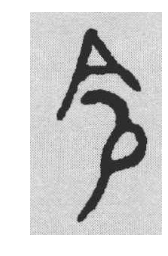

In [6]:
imgpath=random.choice(imgs)
img = Image.open(imgpath)
print(imgpath.split('\\')[1])
plt.axis('off')
plt.imshow(img,cmap='gray')


In [7]:
def load_image(path):
    pic = Image.open(path).convert("L")
    pic.thumbnail((64,64), Image.ANTIALIAS)
    picarr = np.array(pic, dtype=np.float32)
    array = np.zeros((1, 64, 64), dtype=np.float32)
    array[0, :picarr.shape[0], :picarr.shape[1]] = picarr
    return np.ascontiguousarray(array) / 255.0


random.shuffle(imgs)
idx=0
def get_next_minibatch(minibatch_size):
    global idx
    features=[]
    labels=[]
    while len(features)<minibatch_size:
        arr=load_image(imgs[idx])
        features.append(arr)
        
        word=imgs[idx].split('\\')[1]
        widx=word2idx[word]
        onehot=np.zeros(100,dtype=np.float32)
        onehot[widx]=1
        labels.append(onehot)
        idx+=1
        if idx>=len(imgs)-1:
            idx=0
    return np.asarray(features), np.asarray(labels)



features_x,labels_y=get_next_minibatch(3)
print(features_x.shape)
print(labels_y.shape)

(3, 1, 64, 64)
(3, 100)


In [8]:
def conv_bn(input, filter_size, num_filters, strides=(1, 1), init=C.he_normal(), bn_init_scale=1):
    c = Convolution(filter_size, num_filters, activation=None, init=init, pad=True, strides=strides, bias=False)(input)
    r = BatchNormalization(map_rank=1)(c)
    return r

def conv_bn_relu(input, filter_size, num_filters, strides=(1, 1), init=C.he_normal()):
    r = conv_bn(input, filter_size, num_filters, strides, init, 1)
    return relu(r)

#
# ResNet單元結構
#
def resnet_basic(input, num_filters):
    c1 = conv_bn_relu(input, (3, 3), num_filters)
    c2 = conv_bn(c1, (3, 3), num_filters, bn_init_scale=1)
    p = c2 + input
    return relu(p)

def resnet_basic_inc(input, num_filters, strides=(2, 2)):
    c1 = conv_bn_relu(input, (3, 3), num_filters, strides)
    c2 = conv_bn(c1, (3, 3), num_filters, bn_init_scale=1)
    s = conv_bn(input, (1, 1), num_filters, strides) # Shortcut
    p = c2 + s
    return relu(p)

def resnet_basic_stack(input, num_stack_layers, num_filters): 
    assert(num_stack_layers >= 0)
    l = input
    for _ in range(num_stack_layers):
        l = resnet_basic(l, num_filters)
    return l


#根據指定stack數建構resnet
def create_resnet_model(input,c_map = [16, 64, 128], num_stack_layers=5, num_classes=100):
    input=input/255.0   #將圖片除以255，這樣所有值會落在0~1之間
    conv = conv_bn_relu(input, (3, 3), c_map[0])
    r1 = resnet_basic_stack(conv, num_stack_layers, c_map[0])
    r2_1 = resnet_basic_inc(r1, c_map[1])
    r2_2 = resnet_basic_stack(r2_1, num_stack_layers-1, c_map[1])
    r3_1 = resnet_basic_inc(r2_2, c_map[2])
    r3_2 = resnet_basic_stack(r3_1, num_stack_layers-1, c_map[2])

    # Global average pooling and output
    pool = AveragePooling(filter_shape=(8, 8), name='final_avg_pooling')(r3_2)
    z = Dense(num_classes, init=C.he_normal(0.01),activation=softmax)(pool)
    return z

In [9]:
def plot_history(history):
    plt.plot(history['acc1'])
    plt.plot(history['acc2'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('mbs')
    plt.legend(['resnet01', 'resnet02'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss1'])
    plt.plot(history['loss2'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('mbs')
    plt.legend(['resnet01', 'resnet02'], loc='upper left')
    plt.show()

In [10]:
# 訓練模型
def train():
    # 模型變數
    input_var = C.input_variable((1, 64, 64), dtype=np.float32)
    label_var = C.input_variable(100)
    
    resnet01 = create_resnet_model(input_var,[16, 64, 128],5,100)
    resnet02 = create_resnet_model(input_var,[32, 128, 256],5,100)
    
    history={}
    history['acc1']=[]
    history['acc2']=[]
    history['loss1']=[]
    history['loss2']=[]
    history['mbs']=[]
    

    #如果有歷史的模型存檔，則載入將續上次進度繼續訓練
    if os.path.exists('Models/hanzi_resnet01_cntk.cnn'):
        resnet =Function.load('Models/hanzi_resnet01_cntk.cnn')
        print("existing nextword_model loaded!!")
    if os.path.exists('Models/hanzi_resnet02_cntk.cnn'):
        resnet =Function.load('Models/hanzi_resnet02_cntk.cnn')
        print("existing nextword_model loaded!!")
    n=1
    for resmodel in [resnet01,resnet02]:
        z = resmodel(input_var)
        # 損失函數與錯誤率
        loss = cross_entropy_with_softmax(z, label_var)
        errs = classification_error(z, label_var)

        log_number_of_parameters(z)
        learning_rate=0.00001
        momentum=0.95
        l1_regularization_weight=0.001
        l2_regularization_weight=5e-4
        minibatch_size=16
        num_epochs=3
        progress_printer = ProgressPrinter(freq=200, tag='Training', num_epochs=num_epochs)
        learner = adam(z.parameters, lr=learning_rate_schedule([learning_rate], UnitType.sample, num_epochs),
                            momentum=momentum_as_time_constant_schedule([minibatch_size / -math.log(momentum)], epoch_size=num_epochs),
                            l1_regularization_weight=l1_regularization_weight, l2_regularization_weight=l2_regularization_weight)

        trainer = Trainer(z, (loss, errs), learner, progress_printer)
        for epoch in range(num_epochs):
            mbs=0
            while mbs <40000//minibatch_size:
                raw_features,raw_labels = get_next_minibatch(minibatch_size)
                # 定義數據如何對應變數
                trainer.train_minibatch({input_var:raw_features,label_var:raw_labels})
                if mbs%5==0:
                    history['loss{0}'.format(n)].append(trainer.previous_minibatch_loss_average)
                    history['acc{0}'.format(n)].append(trainer.previous_minibatch_evaluation_average)
                    history['mbs'].append(epoch*(40000//minibatch_size)+mbs)
                if mbs%10==0:
                    z.save('Models/hanzi_resnet0{0}_cntk.cnn'.format(n))
                mbs+=1
            trainer.summarize_training_progress()
        n+=1
    plot_history(history)

existing nextword_model loaded!!
Training 2815700 parameters in 101 parameter tensors.
Learning rate per 1 samples: 1e-05
 Minibatch[   1- 200]: loss = 4.605211 * 3200, metric = 99.00% * 3200;
 Minibatch[ 201- 400]: loss = 4.605518 * 3200, metric = 98.91% * 3200;
 Minibatch[ 401- 600]: loss = 4.605472 * 3200, metric = 98.62% * 3200;
 Minibatch[ 601- 800]: loss = 4.604742 * 3200, metric = 98.78% * 3200;
 Minibatch[ 801-1000]: loss = 4.603975 * 3200, metric = 98.56% * 3200;
 Minibatch[1001-1200]: loss = 4.604158 * 3200, metric = 98.72% * 3200;
 Minibatch[1201-1400]: loss = 4.603916 * 3200, metric = 98.66% * 3200;
 Minibatch[1401-1600]: loss = 4.601064 * 3200, metric = 98.22% * 3200;
 Minibatch[1601-1800]: loss = 4.602817 * 3200, metric = 98.47% * 3200;
 Minibatch[1801-2000]: loss = 4.597441 * 3200, metric = 97.62% * 3200;
 Minibatch[2001-2200]: loss = 4.600229 * 3200, metric = 97.91% * 3200;
 Minibatch[2201-2400]: loss = 4.598882 * 3200, metric = 97.88% * 3200;
Finished Epoch[1 of 3]: [T

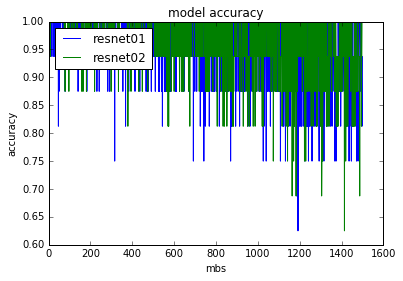

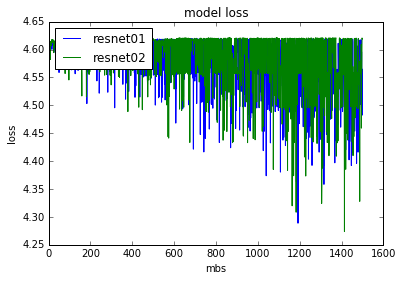

In [11]:
train()